In [1]:
import torch
from torch.utils.data import DataLoader

from zennit.core import BasicHook, Stabilizer, ParamMod
from zennit.composites import LayerMapComposite
from zennit.attribution import Gradient
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.types import Linear

from helpers import (
    get_torchvision_model,
    get_imagenet_dataset,
    denormalize_image,
    img_to_np,
)



class RapRule(BasicHook): # RelPropSimple
    def __init__(self, stabilizer=1e-9):
        stabilizer_fn = Stabilizer.ensure(stabilizer)
        input_modifiers = [
            lambda input: input.clamp(min=0), # px
            lambda input: input.clamp(min=0), # px
            lambda input: input.clamp(max=0), # nx
            lambda input: input.clamp(max=0), # nx
        ]
        param_modifiers = [
            ParamMod(modifier=lambda w, k: w.clamp(min=0), param_keys=["weight"]), # pw
            ParamMod(modifier=lambda w, k: w.clamp(max=0), param_keys=["weight"]), # nw
            ParamMod(modifier=lambda w, k: w.clamp(min=0), param_keys=["weight"]), # pw
            ParamMod(modifier=lambda w, k: w.clamp(max=0), param_keys=["weight"]), # nw
        ]
        # Then, outputs are = [pp(1), pn(2), np(3), nn(4)]

        def rap_gradient_mapper(out_grad, _outputs):
            global outputs
            outputs = [out_grad.ne(0).type(out_grad.type()) * output for output in _outputs]
            _outputs = outputs[:2], outputs[2:]
            out_grad_p, out_grad_n = out_grad.clamp(min=0), out_grad.clamp(max=0)
            gradient_outputs = []
            for output in _outputs:
                s1p = out_grad_p * (1-1e-9) / stabilizer_fn(output[0])
                s1n = out_grad_n * (1-1e-9) / stabilizer_fn(output[0])
                gradient_outputs.append(s1p+s1n)
                s2p = out_grad_p * output[1] / stabilizer_fn(sum(output)) / stabilizer_fn(output[1])
                s2n = out_grad_n * output[1] / stabilizer_fn(sum(output)) / stabilizer_fn(output[1])
                gradient_outputs.append(s2p+s2n)
            return gradient_outputs
        
        def rap_reducer(inputs, gradients):
            return sum([input*gradient for input, gradient in zip(inputs, gradients)])

        super().__init__(
            input_modifiers=input_modifiers,
            param_modifiers=param_modifiers,
            output_modifiers=[lambda output: output] * 4,
            gradient_mapper=(rap_gradient_mapper),
            reducer=(rap_reducer),
        )

    def backward(self, module, grad_input, grad_output):
        '''Backward hook to compute LRP based on the class attributes.'''
        original_input = self.stored_tensors['input'][0].clone()
        inputs = []
        outputs = []
        for in_mod, param_mod, out_mod in zip(self.input_modifiers, self.param_modifiers, self.output_modifiers):
            input = in_mod(original_input).requires_grad_()
            with ParamMod.ensure(param_mod)(module) as modified, torch.autograd.enable_grad():
                output = modified.forward(input)
                output = out_mod(output)
            inputs.append(input)
            outputs.append(output)
        grad_outputs = self.gradient_mapper(grad_output[0], outputs)
        gradients = torch.autograd.grad(
            outputs,
            inputs,
            grad_outputs=grad_outputs,
            create_graph=grad_output[0].requires_grad
        )
        relevance = self.reducer(inputs, gradients)
        return tuple(relevance if original.shape == relevance.shape else None for original in grad_input)        

model, transform = get_torchvision_model("resnet18")
dataset = get_imagenet_dataset(transform)
dataloader = DataLoader(dataset, batch_size=8)
inputs, labels = next(iter(dataloader))

canonizers = [SequentialMergeBatchNorm()]
composite = LayerMapComposite(canonizers=canonizers, layer_map=[(Linear, RapRule())])
with Gradient(model=model, composite=composite) as attributor:
    _, attrs = attributor(inputs, torch.eye(1000)[labels])

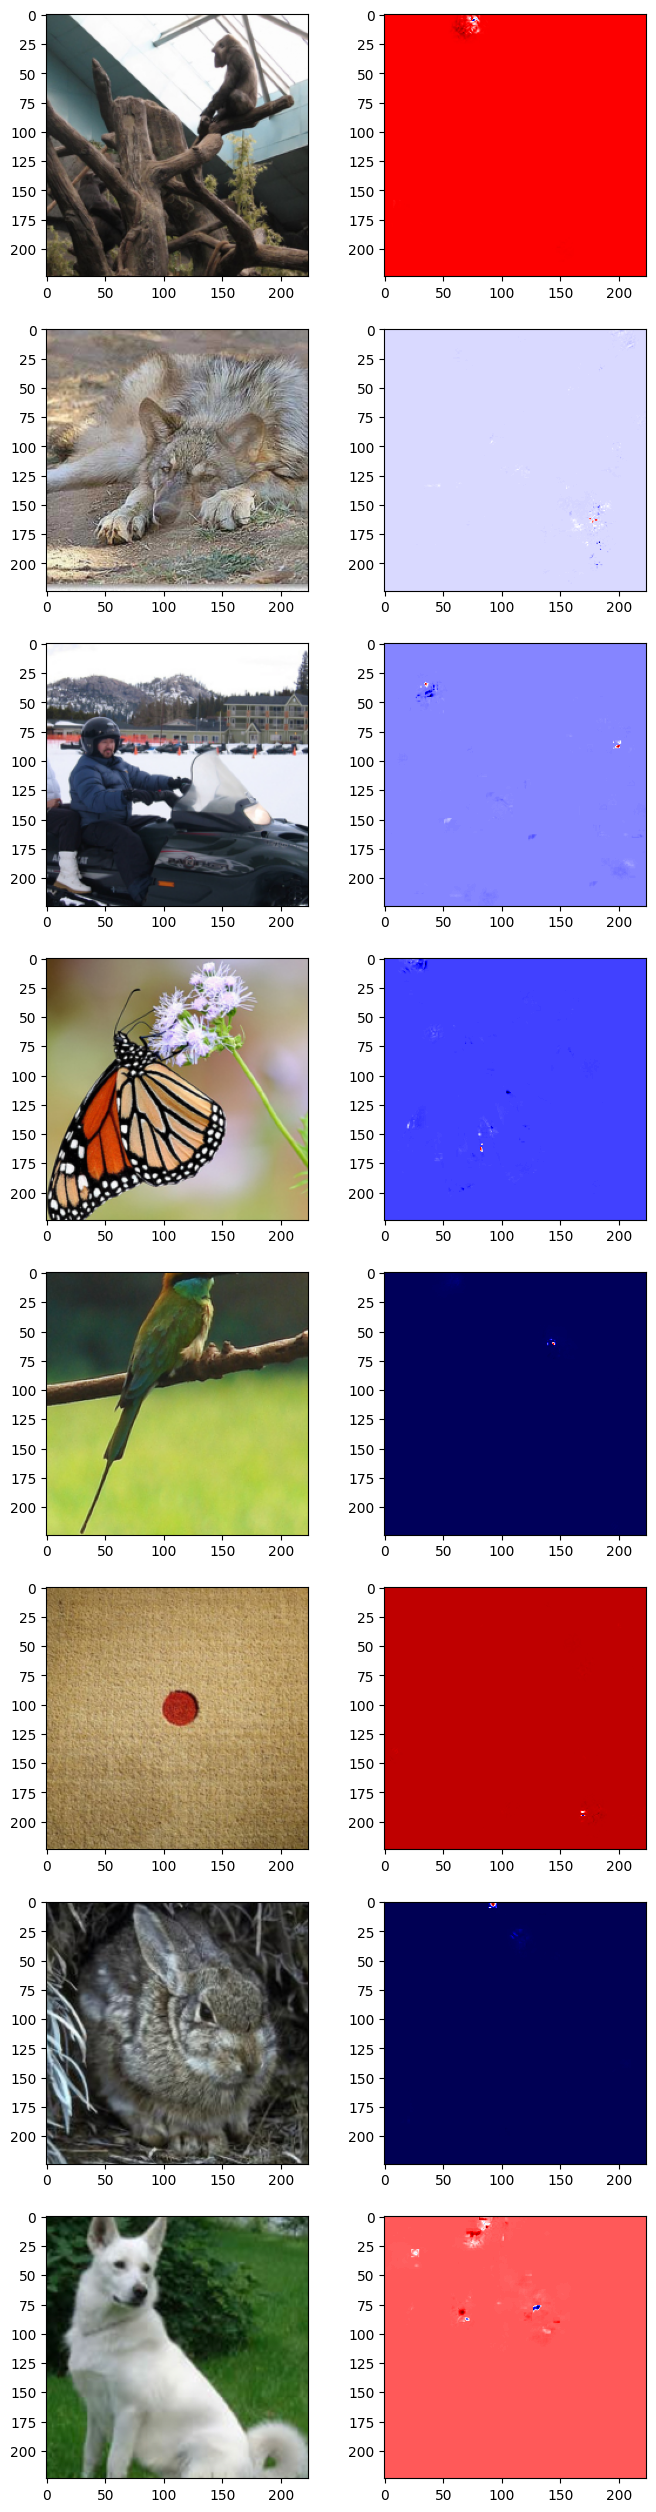

In [2]:
import matplotlib.pyplot as plt

# post process for viz
def post_process(attr):
    # attr = torch.nn.functional.relu(attr)
    postprocessed = attr.permute((1, 2, 0)).sum(dim=-1)
    attr_max = torch.max(postprocessed)
    attr_min = torch.min(postprocessed)
    postprocessed = (postprocessed - attr_min) / (attr_max - attr_min)
    return postprocessed.cpu().detach().numpy()

fig, axes = plt.subplots(8, 2, figsize=(8, 32))
for i, attr in enumerate(attrs):
    axes[i, 0].imshow(img_to_np(denormalize_image(inputs[i], mean=transform.mean, std=transform.std)))
    axes[i, 1].imshow(post_process(attr), cmap="seismic")
